In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info logs

from models import *

2024-12-05 08:29:43.512371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733408983.523214 1328511 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733408983.526369 1328511 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
nan_value = tf.constant(float('nan'), dtype=tf.float32)
input0 = tf.Variable(tf.zeros([1, *NEW_INPUT_SHAPE], dtype=tf.float32))  # Example tensor

indices = [[0, 0, 0, 0]]
updates = [nan_value]
input0 = tf.tensor_scatter_nd_update(input0, indices, updates)

I0000 00:00:1733408984.892771 1328511 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9867 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
print(nan_value)

tf.Tensor(nan, shape=(), dtype=float32)


In [4]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Concatenate
from keras.optimizers import Adam
import tensorflow as tf

class MINE(Model):
    def __init__(self, input_dim, hidden_dim):
        super(MINE, self).__init__()
        # Define the network for MI estimation
        self.dense1 = Dense(hidden_dim, activation='relu')
        self.dense2 = Dense(hidden_dim, activation='relu')
        self.output_layer = Dense(1)
    
    def call(self, x, y):
        # Joint distribution input
        joint_input = Concatenate(axis=1)([x, y])
        joint_score = self.output_layer(self.dense2(self.dense1(joint_input)))
        
        # Marginal distribution input (shuffled y)
        shuffled_y = tf.random.shuffle(y)
        marginal_input = Concatenate(axis=1)([x, shuffled_y])
        marginal_score = self.output_layer(self.dense2(self.dense1(marginal_input)))
        
        return joint_score, marginal_score


In [5]:
def train_mine(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128):
    optimizer = Adam(learning_rate=lr)

    # Custom training step
    @tf.function
    def train_step(x_batch, y_batch):
        with tf.GradientTape() as tape:
            # Forward pass
            joint_score, marginal_score = mine_model(x_batch, y_batch)
            
            # MI estimation
            mi_estimation = tf.reduce_mean(joint_score) - tf.math.log(tf.reduce_mean(tf.exp(marginal_score)))
            
            # Loss for optimization (negative MI)
            loss = -mi_estimation
        
        # Backpropagation
        gradients = tape.gradient(loss, mine_model.trainable_variables)
        clipped_gradients = [tf.clip_by_value(g, -5.0, 5.0) for g in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, mine_model.trainable_variables))
        
        return mi_estimation

    # Prepare dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1024).batch(batch_size)
    
    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            mi_estimation = train_step(x_batch, y_batch)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MI Estimation: {mi_estimation.numpy()}")
    
    return mi_estimation.numpy()


def train_mine_with_logging(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128):
    optimizer = Adam(learning_rate=lr)
    mi_history = []

    @tf.function
    def train_step(x_batch, y_batch):
        with tf.GradientTape() as tape:
            joint_score, marginal_score = mine_model(x_batch, y_batch)
            mi_estimation = tf.reduce_mean(joint_score) - tf.math.log(tf.reduce_mean(tf.exp(marginal_score)))
            loss = -mi_estimation
        gradients = tape.gradient(loss, mine_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, mine_model.trainable_variables))
        return mi_estimation

    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1024).batch(batch_size)

    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            mi_estimation = train_step(x_batch, y_batch)
        mi_history.append(mi_estimation.numpy())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MI Estimation: {mi_estimation.numpy()}")

    return mi_history



Epoch 0, MI Estimation: 0.012985806912183762
Epoch 100, MI Estimation: 1.1876299381256104
Epoch 200, MI Estimation: 0.6074230670928955
Epoch 300, MI Estimation: 1.3031234741210938
Epoch 400, MI Estimation: 1.3392229080200195
Epoch 500, MI Estimation: 1.1836597919464111
Epoch 600, MI Estimation: 1.0925133228302002
Epoch 700, MI Estimation: 1.1255607604980469
Epoch 800, MI Estimation: 0.9830927848815918
Epoch 900, MI Estimation: 1.2931480407714844


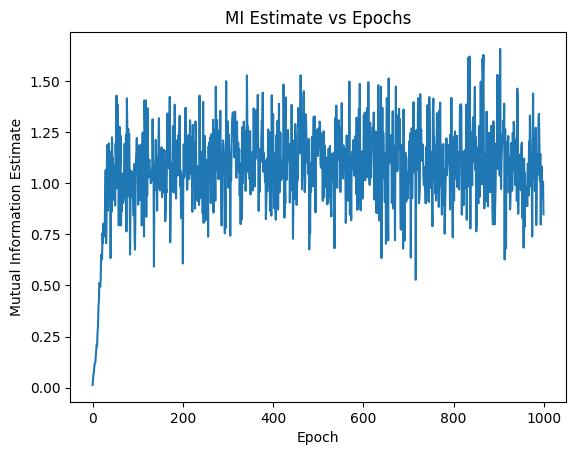

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Generate random data
num_samples = 1000
x = np.random.rand(num_samples, 1).astype(np.float32)  # Input features
y = (x + np.random.normal(0, 0.1, size=(num_samples, 1))).astype(np.float32)  # Labels with noise

# Instantiate and train MINE
mine_model = MINE(input_dim=2, hidden_dim=32)
# Training and logging
mi_history = train_mine_with_logging(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128)

# Plot MI estimate
plt.plot(range(len(mi_history)), mi_history)
plt.xlabel('Epoch')
plt.ylabel('Mutual Information Estimate')
plt.title('MI Estimate vs Epochs')
plt.show()


In [7]:
import pisces.data_sets as pds

# Load the dataset
DATA_DIR = '../../data'
sets = pds.DataSetObject.find_data_sets(DATA_DIR)


/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
sets.keys()

dict_keys(['hybrid_motion', 'hf_disordered', 'walch_et_al'])

In [9]:
walch = sets['walch_et_al']
walch.parse_data_sets()

In [12]:
from pisces.utils import build_ADS
w0_id = walch.ids[0]
w0_acc = walch.get_feature_data('accelerometer', w0_id)
w0_psg = walch.get_feature_data('psg', w0_id)
w0_activity_time, w0_activity = build_ADS(w0_acc, resample_hz=32, bin_size_seconds=30)

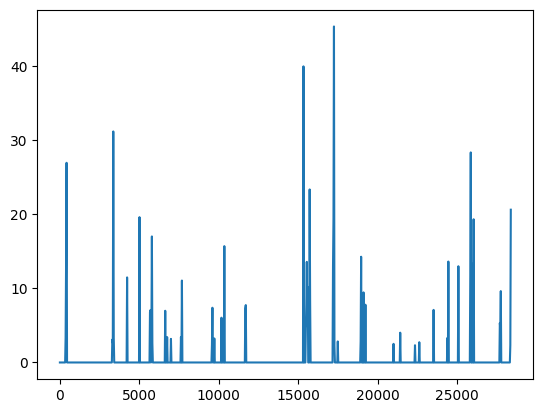

In [13]:

plt.plot(w0_activity_time, w0_activity)

Epoch 0, MI Estimation: -0.03136828541755676
Epoch 100, MI Estimation: 0.08244793862104416
Epoch 200, MI Estimation: 0.1353062093257904
Epoch 300, MI Estimation: -0.12063553929328918
Epoch 400, MI Estimation: 0.04778027534484863
Epoch 500, MI Estimation: 0.156692773103714
Epoch 600, MI Estimation: -0.05743926763534546
Epoch 700, MI Estimation: 0.05509456992149353
Epoch 800, MI Estimation: 0.11516374349594116
Epoch 900, MI Estimation: 0.11863470077514648


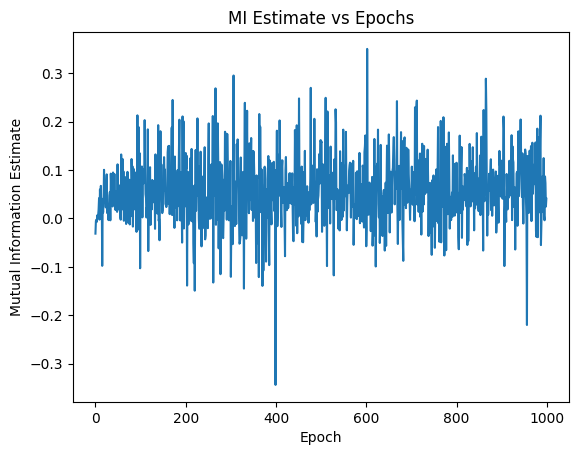

In [19]:
mine_model = MINE(input_dim=2, hidden_dim=32)

mine_x = w0_activity.reshape(-1, 1)
mine_y = w0_psg[:, 1].to_numpy().reshape(-1, 1)

# pad both arrays to be the same length
min_len = min(len(mine_x), len(mine_y))
mine_x = mine_x[:min_len]
mine_y = mine_y[:min_len]

# Training and logging
mi_history = train_mine_with_logging(mine_model, mine_x, mine_y,  epochs=1000, lr=1e-3, batch_size=128)

# Plot MI estimate
plt.plot(range(len(mi_history)), mi_history)
plt.xlabel('Epoch')
plt.ylabel('Mutual Information Estimate')
plt.title('MI Estimate vs Epochs')
plt.show()


In [20]:
from sklearn.feature_selection import mutual_info_regression

In [43]:
def rolling_window(x: np.ndarray, window_size: int) -> np.ndarray:
    """
    Create a rolling window view of the input array.
    """
    # shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
    # strides = x.strides + (x.strides[-1],)
    return np.lib.stride_tricks.sliding_window_view(x, window_shape=(window_size,))

In [44]:
sw_psg = np.where(w0_psg[:, 1] > 0, 1, w0_psg[:, 1])

In [45]:
WINDOW = 61
wrapped_activity = rolling_window(w0_activity, WINDOW)
wrapped_time = rolling_window(w0_activity_time, WINDOW)

In [46]:
wrapped_activity.shape

(887, 61)

In [47]:
w0_activity.shape

(947,)

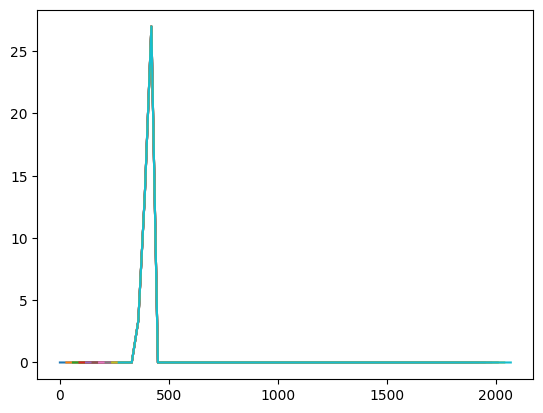

In [48]:
for i in range(10):
    plt.plot(wrapped_time[i], wrapped_activity[i])

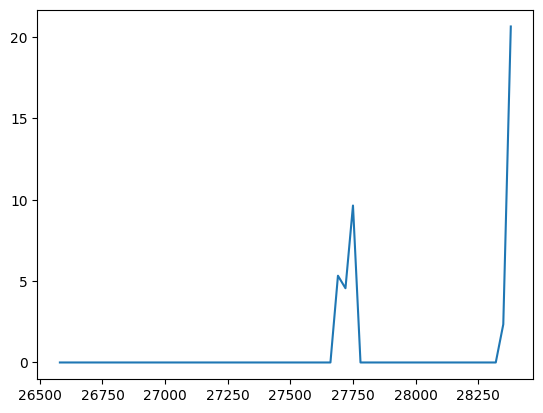

In [50]:
plt.plot(wrapped_time[-1], wrapped_activity[-1])

In [51]:
rand_idx

93

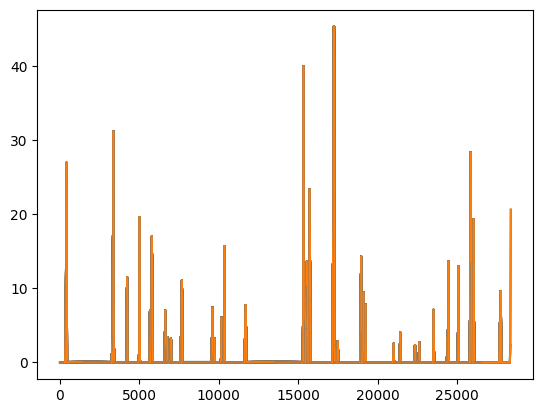

In [56]:
for i in range(wrapped_activity.shape[0]):
    plt.plot(wrapped_time[i], wrapped_activity[i], c='tab:blue')
    plt.plot(w0_activity_time[i:i+WINDOW], w0_activity[i:i+WINDOW], c='tab:orange')

In [83]:
n_windows = wrapped_activity.shape[0]

neighbors = list(range(3, 20))


mi = np.array([
    mutual_info_regression(wrapped_activity[:-1], w0_activity[WINDOW:], n_neighbors=N)
    for N in neighbors
])

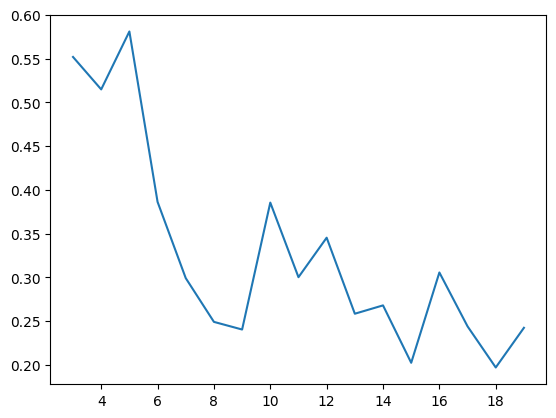

In [85]:
plt.plot(neighbors, np.sum(mi, axis=-1))

In [82]:
np.sum(mi)

np.float64(0.33099244213263024)